# 互评作业1：探索性分析与预处理（1/2）

运行此notebook需要matplotlib库。

本次互评作业使用的两个数据集是：1) Wine Reviews；2）Oakland Crime Statistics 2011-2016。下面展示对于第一个数据集Wine Reviews的预处理过程，第二个数据集Oakland Crime Statistics 2011-2016的预处理在另一个文件之中。

## 数据集1：Wine Reviews

[Wine Rewiew](https://www.kaggle.com/zynicide/wine-reviews)，顾名思义是一个关于葡萄酒评价的数据集，包含酒的原产国、描述、评分、价格、产地等等信息。该数据集包含两个csv文件和一个json文件：

In [1]:
import csv
import json
import matplotlib.pyplot as plt

fcsv_130kv2 = open('Wine Reviews/winemag-data-130k-v2.csv')
fcsv_150k = open('Wine Reviews/winemag-data_first150k.csv')
csv130v2 = csv.reader(fcsv_130kv2)
csv150 = csv.reader(fcsv_150k)

fjson_130kv2 = open('Wine Reviews/winemag-data-130k-v2.json')
json130v2 = json.load(fjson_130kv2)

让我们看看两个CSV文件都有哪些列：

In [2]:
columns_130 = next(csv130v2)
print(columns_130)
columns_150 = next(csv150)
print(columns_150)

['', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']
['', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety', 'winery']


可以说这两个数据集的各个列基本相同，但是130k的数据集额外多出关于品酒师的信息：名称，推特handle以及品酒报告的标题。由于第二版（130k）的数据新增了更多的信息，所以我们接下来的分析使用第二版数据。实际上，json文件和csv文件保存的是同样的数据。

我们进行一个简单的验证。首先验一下总数是否相等，其次依次查看每条数据的评分。

In [3]:
rows_130 = [row for row in csv130v2]
print(f'csv数据集中有{len(rows_130)}条数据')
print(f'json数据集中有{len(json130v2)}条数据')

data_count = len(rows_130)
mismatch_count = 0 # 记录评分不匹配的次数
for i in range(data_count):
    if json130v2[i]['points'] != rows_130[i][4]: #第5列（[4]）为points
        mismatch_count += 1
print(f'不匹配次数:{mismatch_count}')

csv数据集中有129971条数据
json数据集中有129971条数据
不匹配次数:0


这基本上证明了这一点。因此，在接下来的分析中将会同时使用这两个文件，但是表达的数据是同一份。

## 初步分析：数据摘要与可视化

### 数值部分

我们先对数值型数据进行分析。我们定义求五数概括和缺失值个数的方法：

In [4]:
def fivenum_summary(vals):
    '''输入一组数据，依次返回这组数据的最小值、下四分位点、中位数、上四分位点、最大值，即从小到大排序的五个概括数。
    返回的数据都是取自输入的数据，不会进行数学运算。'''
    srted = sorted(vals)
    count = len(vals)
    vmax = srted[-1]
    vmin = srted[0]
    vmid = srted[count // 2]
    vquadlow = srted[count // 4]
    vquadhigh = srted[count*3 // 4]
    return (vmin, vquadlow, vmid, vquadhigh, vmax)

def missing_count(data, columnNo):
    cnt = 0
    for d in data:
        if d[columnNo] == '':
            cnt += 1
    return cnt

除了第0列（编号）之外，数值型的数据总共有points（\[4\]）和price（\[5\]）这两列。我们先看points这一列。

求points列有多少缺失数据：

In [5]:
missing_count(rows_130,4)

0

幸运的是这一列没有任何缺失的数据。接下来求points列的五数概括：

In [6]:
points = [int(data[4]) for data in rows_130]
fivenum_summary(points)

(80, 86, 88, 91, 100)

并且给出这一列的盒图：

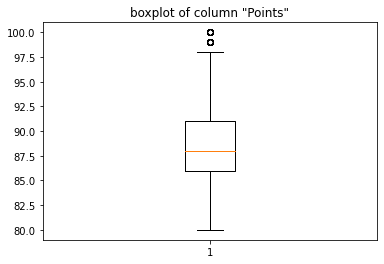

In [7]:
plt.figure()
plt.title('boxplot of column "Points"')
plt.boxplot(points)
plt.show()

我们进行五数概括所得的结果与盒图的结果不完全相同，这是因为盒图剔除了一些离群点。

之后，我们处理price这一列。  
先看这一列有多少缺失的数值：

In [8]:
fivenum = fivenum_summary(points)
iqr = fivenum[3]-fivenum[1]
q1 = fivenum[1]
q3 = fivenum[3]
iqr = q3-q1
outliers = [i for i in points if ((i<q1-1.5*iqr) or (i>q3+1.5*iqr))]
len(outliers)

52

这52个离群点，其评分要么是98要么是100，显示在图上只有两个点。

现在我们处理price这一列。  
先看这一列有多少缺失的数值：

In [9]:
missing_cnt = missing_count(rows_130,5)
(missing_cnt,missing_cnt/data_count)

(8996, 0.06921544036746659)

8996个数据是缺失的，占总体的6.9%。

之后，我们给出五数概括和盒图：

In [10]:
prices = [float(data[5]) for data in rows_130 if data[5]!='']
fivenum_summary(prices)

(4.0, 17.0, 25.0, 42.0, 3300.0)

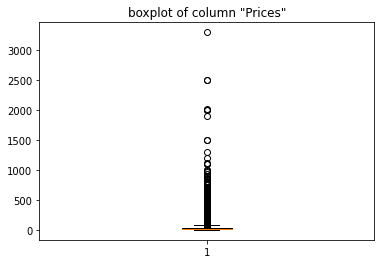

In [11]:
plt.figure()
plt.title('boxplot of column "Prices"')
plt.boxplot(prices)
plt.show()

看上去有很多离群点，所以统计离群点的数目：

In [12]:
fivenum = fivenum_summary(prices)
iqr = fivenum[3]-fivenum[1]
q1 = fivenum[1]
q3 = fivenum[3]
iqr = q3-q1
outliers = [i for i in prices if ((i<q1-1.5*iqr) or (i>q3+1.5*iqr))]
len(outliers)

7241

7000+离群点看上去很多，但考虑到数据的数目（13万）以及离群点离整体的距离（大多数酒品的价格都在100元以下，但这些离群点的价格往往成百上千），这个值并非十分不正常。

价格数据的离群点情况也反映了一个现象，就是价格贵的红酒售价可以远远高于一般红酒，即使其评分并没有如此显著的差异（注意到评分的离群点仅有52个）。

数值部分的最后，我们绘制points到price的Q-Q图。绘制过程中剔除了上述离群点。从图中可以看出，points和price之间存在着较弱的正相关性。

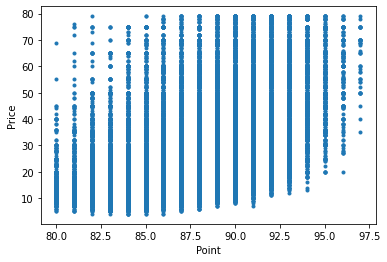

In [13]:
q_point=[]
q_price=[]
for data in rows_130:
    if data[5]=='':continue
    if float(data[5]) in outliers: continue
    if int(data[4]) >= 98: continue
    q_point.append(int(data[4]))
    q_price.append(float(data[5]))
plt.figure()
plt.xlabel('Point')
plt.ylabel('Price')
plt.plot(q_point,q_price,'.')
plt.show()

### 标称部分

相应列中，country，province，和variety是标称属性。后续需要绘制条形图，这里先对相关方法进行定义，供后续调用。

In [14]:
from collections import defaultdict # 用于统计数目

def count_occurence(data,column,ignore_empty=True):
    count = defaultdict(int)
    for row in data:
        if ignore_empty and row[column]=='':
            continue
        count[row[column]]+=1
    return count

def cutoff(datadict,ratio,total_amt=data_count,return_ratio=True):
    ret = {}
    for key in datadict:
        val = datadict[key]
        percent = val/total_amt
        if percent>=ratio:
            ret[key]=percent*100 if return_ratio else val
    return ret

def plot_barchart(title,Xlabel,Ylabel,data,do_sort=False,bar_width=0.4):
    plt.figure(title)
    plt.title(title)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    count = len(data) # 有几个bars要画
    keys = list(data.keys())
    if do_sort:
        keys.sort(key=lambda k:data[k],reverse=True)
    for i,name in enumerate(keys):
        plt.bar(
            i,# 横向位置
            data[name], #数据
            width = bar_width, # 宽度
            # 边缘
            ec='k',lw=1
        )
    plt.xticks([i for i in range(count)],list(keys))
    plt.show()

我们先处理country。看一下它的缺失值数量：

In [15]:
missing_cnt = missing_count(rows_130,1)
missing_cnt, missing_cnt/data_count

(63, 0.0004847235152457087)

有63条数据缺失，占总数据的万分之4.8。

之后我们绘制数据的条形图，如下所示。由于国家数目太多，我们只选取占2%以上的国家画图。横轴为原产国，纵轴为在所有数据中的占比。

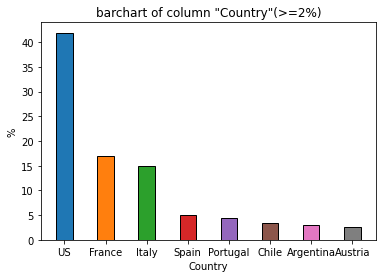

In [16]:
# Remove掉占比小于2%的国家
country_displayed=cutoff(count_occurence(rows_130,1),.02)
plot_barchart('barchart of column "Country"(>=2%)','Country',"%",country_displayed,True)

处理province和variety属性的部分也是类似。

province属性的缺失值个数和占比：

In [17]:
missing_cnt = missing_count(rows_130,6)
missing_cnt,missing_cnt/data_count

(63, 0.0004847235152457087)

缺失的数据条目数量与country的相同，可能是因为这两列数据的缺失是同时发生的。该属性的条形图如下。分别制作了一张仅截取占比大于3%的条形图和大于0.5%的条形图。后者由于条目数量过多，横轴标签会挤在一起。

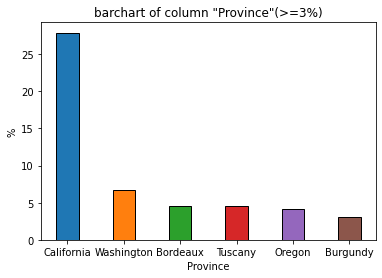

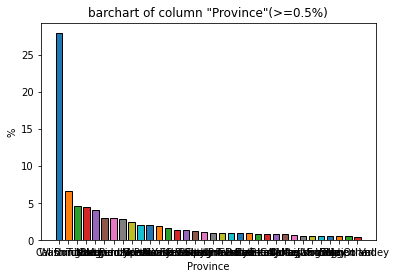

In [18]:
province_all = count_occurence(rows_130,6)
province_disp = cutoff(province_all,.03)
province_more = cutoff(province_all,.005)
plot_barchart('barchart of column "Province"(>=3%)','Province',"%",province_disp,True)
plot_barchart('barchart of column "Province"(>=0.5%)','Province',"%",province_more,True,bar_width=0.7)

现在讨论variety属性。

variety属性的缺失值个数和占比：

In [19]:
missing_cnt = missing_count(rows_130,12)
missing_cnt,missing_cnt/data_count

(1, 7.694024051519185e-06)

存在唯一一个缺失值。该属性的条形图如下图所示：

存在706种不同的variety


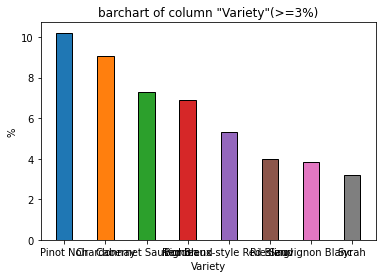

In [20]:
variety_count=count_occurence(rows_130,12)
print(f'存在{len(variety_count)-1}种不同的variety')
variety_disp=cutoff(variety_count,.03)
plot_barchart('barchart of column "Variety"(>=3%)','Variety',"%",variety_disp,True)

由于variety的名称过长，我们用列表的方法将上述条形图重新展示一遍：

In [21]:
print('%\tVariety')
keys = list(variety_disp.keys())
keys.sort(key=lambda k:variety_disp[k],reverse=True)
for v in keys:
    print(f'{variety_disp[v]:.2f}\t{v}')

%	Variety
10.21	Pinot Noir
9.04	Chardonnay
7.29	Cabernet Sauvignon
6.88	Red Blend
5.32	Bordeaux-style Red Blend
3.99	Riesling
3.82	Sauvignon Blanc
3.19	Syrah


### 特殊属性：品酒师姓名taster_name

虽然品酒师似乎不应当作为一个有固定取值范围的标称型属性出现，但实际上数据集中给出姓名的品酒师数量并不是很多。因此，在此将其暂时当做标称属性处理，展示其取值范围和命中次数。从输出中可以发现，数据集中一共出现了19名给出姓名的品酒师，其中包含了15个（不是16个，因为品酒师Jeff Jenson和Mine DeDimone公用一个推特账号@worldwineguys）不相同的推特账号。

In [22]:
tasters = set()
for data in rows_130:
    tasters.add((data[9],data[10]))
tasters

{('', ''),
 ('Alexander Peartree', ''),
 ('Anna Lee C. Iijima', ''),
 ('Anne Krebiehl\xa0MW', '@AnneInVino'),
 ('Carrie Dykes', ''),
 ('Christina Pickard', '@winewchristina'),
 ('Fiona Adams', '@bkfiona'),
 ('Jeff Jenssen', '@worldwineguys'),
 ('Jim Gordon', '@gordone_cellars'),
 ('Joe Czerwinski', '@JoeCz'),
 ('Kerin O’Keefe', '@kerinokeefe'),
 ('Lauren Buzzeo', '@laurbuzz'),
 ('Matt Kettmann', '@mattkettmann'),
 ('Michael Schachner', '@wineschach'),
 ('Mike DeSimone', '@worldwineguys'),
 ('Paul Gregutt', '@paulgwine\xa0'),
 ('Roger Voss', '@vossroger'),
 ('Sean P. Sullivan', '@wawinereport'),
 ('Susan Kostrzewa', '@suskostrzewa'),
 ('Virginie Boone', '@vboone')}

## 数据缺失处理

经过之前的分析，我们可以对数据缺失值的情况进行一个整理：

|列号|键名|类别|缺失值数量|占比|
|:-:|:--:|:-:|:-------:|:-:|
|1|country|标称型|63|0.04%|
|4|points|数值型|0|0.00%|
|5|price|数值型|8996|6.92%|
|6|province|标称型|63|0.04%|
|12|variety|标称型|1|0.00%|

我们先讨论数值型数据的损失处理问题。points数据是很完整的，不需要补全，因此此处考虑对price的数据补全。

最简单地，直接丢弃掉残缺的数据。丢弃后，我们重新看一下各个数据的盒图和条形图。我们发现，丢弃掉这些数据后，variety中出现最多的那个，频率变少了；占比大于3%的省份数量也变少了。说明被丢弃的数据主要来自这里。

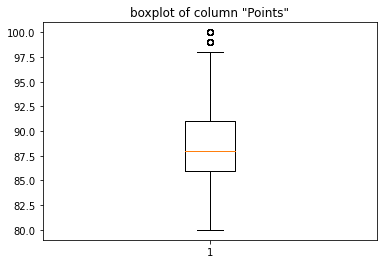

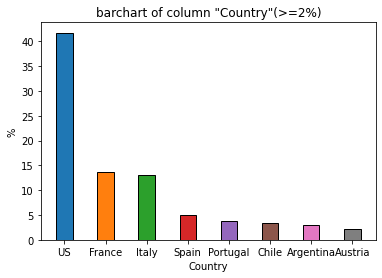

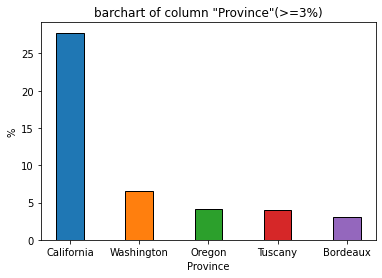

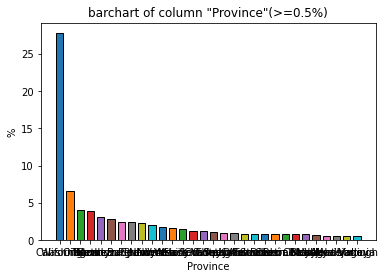

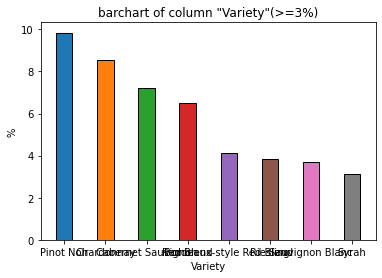

%	Variety
9.84	Pinot Noir
8.52	Chardonnay
7.22	Cabernet Sauvignon
6.52	Red Blend
4.11	Bordeaux-style Red Blend
3.83	Riesling
3.68	Sauvignon Blanc
3.14	Syrah


In [23]:
dropped = [data for data in rows_130 if data[5]!='']
plt.figure()
plt.title('boxplot of column "Points"')
plt.boxplot([int(data[4]) for data in dropped])
plt.show()

country_displayed=cutoff(count_occurence(dropped,1),.02)
plot_barchart('barchart of column "Country"(>=2%)','Country',"%",country_displayed,True)

province_all = count_occurence(dropped,6)
province_disp = cutoff(province_all,.03)
province_more = cutoff(province_all,.005)
plot_barchart('barchart of column "Province"(>=3%)','Province',"%",province_disp,True)
plot_barchart('barchart of column "Province"(>=0.5%)','Province',"%",province_more,True,bar_width=0.7)

variety_disp=cutoff(count_occurence(dropped,12),.03)
plot_barchart('barchart of column "Variety"(>=3%)','Variety',"%",variety_disp,True)
print('%\tVariety')
keys = list(variety_disp.keys())
keys.sort(key=lambda k:variety_disp[k],reverse=True)
for v in keys:
    print(f'{variety_disp[v]:.2f}\t{v}')

第二种处理方式是使用一个高频值来做默认替代。对于数值型变量来说，考虑选用去除离群值后的数据均值来做默认替代。进行补全后，我们重新绘制price的盒图，并计算其（不排除离群点的）五数概括。

(4.0, 18.0, 28.0, 40.0, 3300.0)


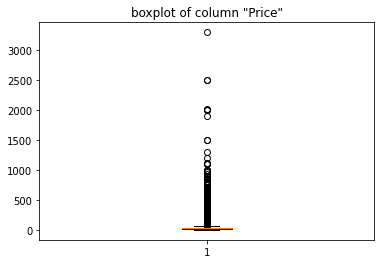

In [24]:
prices = [float(data[5]) for data in rows_130 if data[5]!='']
price_avg = sum(prices)/len(prices)
fixed_filled_price = [(float(data[5]) if data[5]!='' else price_avg) for data in rows_130]
print(fivenum_summary(fixed_filled_price))
plt.figure()
plt.title('boxplot of column "Price"')
plt.boxplot(fixed_filled_price)
plt.show()

我们也可以考虑利用数据间的关系来补全数据。之前的分析显示了points到price间有着一定的正相关性。因此我们简单地构建一个线性方程用于数据补全，当points为80时price为5，当points为97时price为80，如下面的函数所示。进行补全后，我们再来看看效果。

(4.0, 18.0, 27.058823529411764, 44.705882352941174, 3300.0)


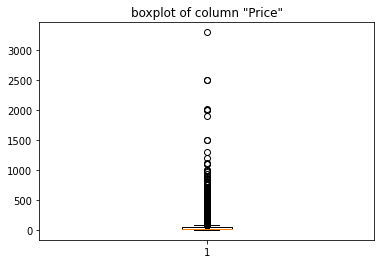

In [25]:
def linear_price(points):
    return 5+(80-5)*(points-80)/(97-80)
linear_filled_price = [(float(data[5]) if data[5]!='' else linear_price(int(data[4]))) for data in rows_130]
print(fivenum_summary(linear_filled_price))
plt.figure()
plt.title('boxplot of column "Price"')
plt.boxplot(linear_filled_price)
plt.show()

可以看到中位数和上四分位数已经变为填充值了。

之后是标称型数据的缺失。我们先讨论country和province的缺失问题。这两个属性缺失的数量完全一致，考虑是否是同时缺失的呢？

In [26]:
# 等号左边是所有country为空的行的行号，等号右边是province为空的
[int(data[0])for data in rows_130 if data[1]==''] == [int(data[0])for data in rows_130 if data[6]=='']

True

这说明这二者确实是同时缺失的。同时考虑到省份和国家的从属关系，确定省份就能确定国家，因而考虑将这两个属性合并处理。

同样，最简单的方式是丢弃掉这些数据。考虑到这些数据占比很小，不会带来很大的变动。因此我们重点关注被丢弃数据的情况：

points的五数概括：(82, 87, 89, 90, 92)
price的五数概括：(6.0, 19.0, 25.0, 30.0, 50.0)


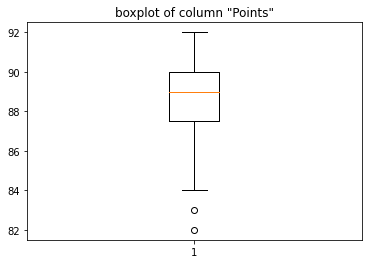

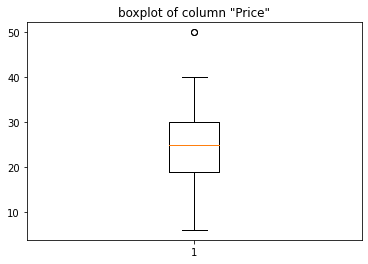

In [27]:
dropped = [data for data in rows_130 if data[1]=='']
print(f'points的五数概括：{fivenum_summary([int(data[4]) for data in dropped])}')
print(f'price的五数概括：{fivenum_summary([float(data[5]) for data in dropped if data[5]!=""])}')
plt.figure()
plt.title('boxplot of column "Points"')
plt.boxplot([int(data[4]) for data in dropped])
plt.show()
plt.figure()
plt.title('boxplot of column "Price"')
plt.boxplot([float(data[5]) for data in dropped if data[5]!=''])
plt.show()

从数据上看，丢弃的部分与其余部分的分布大致相同，被丢弃的部分没有前面提到过的高价酒。

也可以使用最常出现的值来填充：

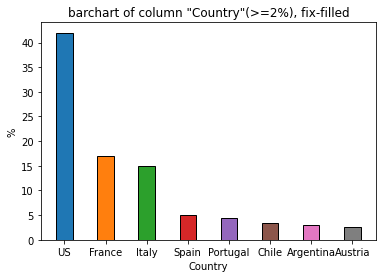

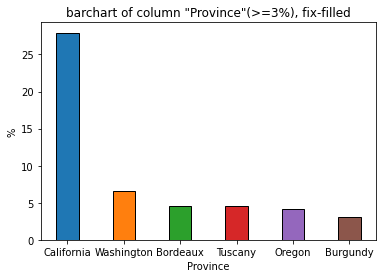

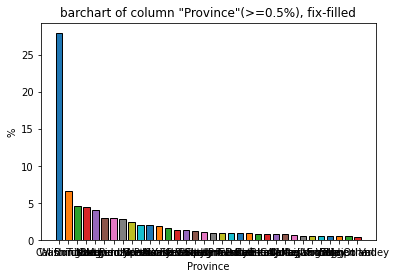

In [28]:
fixed_country = [[data[1] if data[1] != '' else 'US'] for data in rows_130]
fixed_province = [[data[6] if data[6]!=''else 'California'] for data in rows_130]

country_displayed=cutoff(count_occurence(fixed_country,0),.02)
plot_barchart('barchart of column "Country"(>=2%), fix-filled','Country',"%",country_displayed,True)

province_all = count_occurence(fixed_province,0)
province_disp = cutoff(province_all,.03)
province_more = cutoff(province_all,.005)
plot_barchart('barchart of column "Province"(>=3%), fix-filled','Province',"%",province_disp,True)
plot_barchart('barchart of column "Province"(>=0.5%), fix-filled','Province',"%",province_more,True,bar_width=0.7)

最后是关于标称型的属性variety。这个属性只差一个值，认为可以在基本上不影响整体数据的情况下简单丢弃之。我们丢弃掉的数据如下所示。这个数据不仅缺失variety信息，同时还缺失包含designation（酿酒所用葡萄的葡萄园）和region的葡萄产地信息。

In [29]:
variety_dropped = [data for data in rows_130 if data[12]=='']
assert len(variety_dropped) == 1
variety_dropped[0]

['86909',
 'Chile',
 "A chalky, dusty mouthfeel nicely balances this Petite Syrah's bright, full blackberry and blueberry fruit. Wheat-flour and black-pepper notes add interest to the bouquet; the wine finishes with herb and an acorny nuttiness. A good first Chilean wine for those more comfortable with the Californian style. It's got tannins to lose, but it's very good.",
 '',
 '88',
 '17.0',
 'Maipo Valley',
 '',
 '',
 '',
 '',
 'Carmen 1999  (Maipo Valley)',
 '',
 'Carmen']